In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from radio_beam import Beam
from astropy.nddata.utils import Cutout2D

from matplotlib.ticker import MultipleLocator

import numpy as np
import astropy.units as u
from scipy import stats

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in'})

In [66]:
# file_vc_N2Hp = 'data/NGC1333_N2Hp_L28-merged_vc_QA.fits'
# file_vc_N2Dp = 'data/NGC1333_N2Dp_L16-merged_vc_QA.fits'

# file_dv_N2Hp = 'data/NGC1333_N2Hp_L28-merged_dv_QA.fits'
# file_dv_N2Dp = 'data/NGC1333_N2Dp_L16-merged_dv_QA.fits'

# file_TdV_N2Hp = 'data/NGC1333_N2Hp_L28-merged_TdV.fits'
# file_TdV_N2Dp = 'data/NGC1333_N2Dp_L16-merged_TdV.fits'
# file_TdV_N2Hp_cutout = 'data/NGC1333_N2Hp_L28-merged_TdV_cutout.fits'
# file_TdV_N2Dp_cutout = 'data/NGC1333_N2Dp_L16-merged_TdV_cutout.fits'

# file_TdV_SiO = 'data/NGC1333_SiO_L17_TdV_narrow.fits'

# file_TdV_HC3N_L24 = 'data/NGC1333_HC3N_L24-merged_TdV.fits'
file_yso = 'catalogye/NGC1333_protostar_list.txt'

file_TdV_DCOp = 'data/NGC1333_DCOp_L09-merged_SDI_TdV_fix.fits'
file_TdV_H13COp = 'data/NGC1333-H13COp_match_TdV_fix.fits'
file_TdV_DCOp_H13COp = 'data/NGC1333_DCOp_H13COp_ratio.fits'
file_Ncol_DCOp_H13COp = 'data/NGC1333_DCOp_H13COp_ratio_coldens.fits'
file_Ncol_DCOp_HCOp = 'data/NGC1333_DCOp_HCOp_ratio_coldens.fits'

file_N_H2 = 'data/NGC1333_SE_H2.fits'
file_N_C18O = 'data/NGC1333_SE_C18O.fits'
file_N_C18O_Td = 'data/NGC1333_SE_C18O_Td.fits'
X_12CO = 1.5e-4
# 12CO / 13CO = 70
# 13CO / C18O = 8.4
X_C18O = X_12CO / (8.4 * 70)
R_12CO_C18O = 8.4 * 70

ra0 = 52.2923239
dec0 = 31.2304113
width = 0.1010000
height = 0.1150000

rms_TdV_SiO = 10e-3
levels_SiO = np.arange(5, 43, 10) * rms_TdV_SiO

rms_TdV_N2Hp = 2.0
levels_N2Hp = np.arange(3, 20, 3) * rms_TdV_N2Hp

# col_pos = [0.55, 0.3, 0.3, 0.025]
col_pos = [0.6, 0.2, 0.35, 0.025]

xpos_lab1, ypos_lab1 = (0.05, 0.9)
xpos_lab2, ypos_lab2 = (0.05, 0.85)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

my_figsize = (5, 5)

cutout_size = u.Quantity((height, width), u.deg)
position = SkyCoord(ra0 * u.deg, dec0 * u.deg, frame='fk5')

beam_pos = SkyCoord("03h29m23.2s", "31d17m2s", frame='fk5')
scalebar_pos = SkyCoord("03h28m59.5s", "31d10m50s", frame='fk5')

file_xe_fd2 = 'data/NGC1333_xe_fd2.fits'
file_xe_fd3 = 'data/NGC1333_xe_fd3.fits'
file_xe_fd5 = 'data/NGC1333_xe_fd5.fits'
file_xe_fd = 'data/NGC1333_xe_fd.fits'

N_H2 = fits.getdata(file_N_H2)
N_C18O = fits.getdata(file_N_C18O)
N_C18O_Td = fits.getdata(file_N_C18O_Td)

N_CO = N_C18O * R_12CO_C18O
HCOp_TdV, hd_TdV = fits.getdata(file_TdV_H13COp, header=True)
DCOp_TdV, hd_TdV_DCOp = fits.getdata(file_TdV_DCOp, header=True)

# R_H_raw = HCOp_TdV / N_CO

from molecular_columns import col_h13cop, col_dcop
# H12CO+ / H13CO+ = 70
HCOp_Ncol = col_h13cop.H13COp_thin(J_up=1, Tex=10.0*u.K, TdV=HCOp_TdV*u.K*u.km/u.s) * 70.0
DCOp_Ncol = col_dcop.DCOp_thin(J_up=1, Tex=10.0*u.K, TdV=HCOp_TdV*u.K*u.km/u.s)
R_H = HCOp_Ncol.to(u.cm**-2) / (N_CO*u.cm**-2)

R_D = DCOp_Ncol / HCOp_Ncol

hdu_R_D = fits.PrimaryHDU(R_D, hd_TdV_DCOp)
hdu_R_H = fits.PrimaryHDU(R_H, hd_TdV)
print(np.nanmean(HCOp_Ncol)/1e18)

# R_H_med = R_H_raw / np.nanmean(R_H_raw) * 3e-6
n_H2 = 1e3
print(np.nanmean(N_CO))

9.432646424807856e-05 1 / cm2
1.1213630568009505e+18


In [65]:
ra_yso, dec_yso = np.loadtxt(file_yso, unpack=True)
marker_size = 50

In [4]:
distance = 300. # pc

def load_cutout(file_in, is_hdu=False):
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in
    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_noema_wcsaxes(ax, hdu, label_col='black', contour_n2hp=False, contour_sio=False):
    # ticks
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    ra_ax.set_major_formatter('hh:mm:ss')
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
    ra_ax.set_ticks(spacing=8*15 * u.arcsec, color=label_col)
    dec_ax.set_ticks(spacing=2 * u.arcmin, color=label_col)
    ra_ax.set_minor_frequency(4)
    dec_ax.set_minor_frequency(4)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.autoscale(enable=False)
    
    ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='white', edgecolor='black',
                 linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))

    if contour_n2hp:
        hdu_n2hp = load_cutout(file_TdV_N2Hp)
        ax.contour(hdu_n2hp.data, levels=levels_N2Hp, 
                   transform=ax.get_transform(WCS(hdu_n2hp.header)), 
                   colors='black', linewidths=1, alpha=0.5)
    if contour_sio:
        hdu_sio = load_cutout(file_TdV_SiO)
        ax.contour(hdu_sio.data, levels=levels_SiO, 
                   transform=ax.get_transform(WCS(hdu_sio.header)), 
                   colors='black', linewidths=1, alpha=0.5)
    # Add beamsize
    my_beam = Beam.from_fits_header(hdu.header)
    xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos)
    pixscale = np.abs(hdu.header['cdelt1']) * u.deg
    ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
    ellipse_artist.set_color('black')
    _ = ax.add_artist(ellipse_artist)      
    
    # Scalebar
    length = (5e3*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
    ax.plot([scalebar_pos.ra.deg, (scalebar_pos.ra - length).deg]*u.deg,
        [(scalebar_pos.dec).deg]*2*u.deg,
        'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
    ax.text((scalebar_pos.ra - length / 2).deg, (scalebar_pos.dec - 0.004*u.deg).deg,
        "5,000 au", color='k', transform=ax.get_transform('fk5'), ha='center')
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

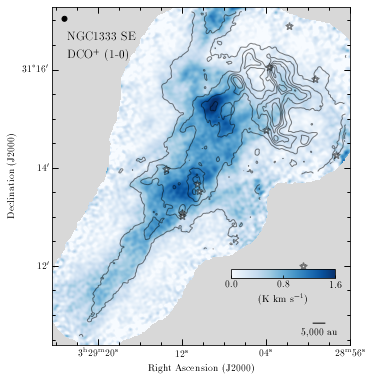

In [14]:
text_color = 'black'

hdu = load_cutout(file_TdV_DCOp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=1.6, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 0.8, 1.6])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'DCO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_DCOp_Tdv_N2Hp.pdf', dpi=200)

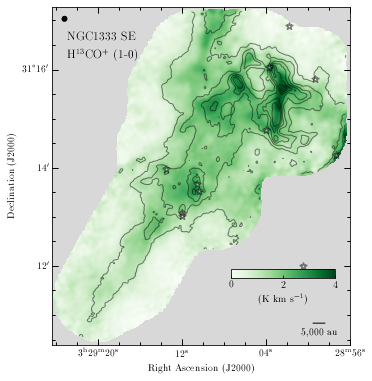

In [15]:
text_color = 'black'

hdu = load_cutout(file_TdV_H13COp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=4.0, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 2, 4])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_H13COp_Tdv_N2Hp.pdf', dpi=200)

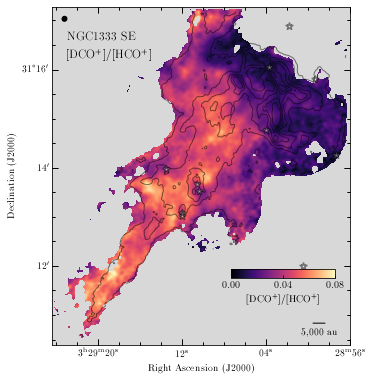

In [16]:
text_color = 'black'

hdu = load_cutout(file_Ncol_DCOp_HCOp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=0.08, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'[DCO$^{+}$]/[HCO$^{+}$]', orientation='horizontal')
cbar.set_ticks([0, 4e-2, 8e-2])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'[DCO$^{+}$]/[HCO$^{+}$]', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_Ncol_DCOp_HCOp.pdf', dpi=200)

/var/folders/2n/6gk_yf0d1zvdwj6wy12h_klr0000gn/T/ipykernel_44747/147554664.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


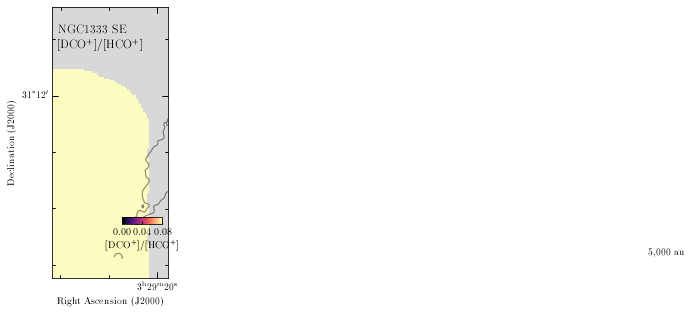

In [68]:
text_color = 'black'

hdu = load_cutout(hdu_R_D, is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=0.08, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'[DCO$^{+}$]/[HCO$^{+}$]', orientation='horizontal')
cbar.set_ticks([0, 4e-2, 8e-2])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'[DCO$^{+}$]/[HCO$^{+}$]', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
# fig.savefig('figs/NGC1333_Ncol_DCOp_HCOp.pdf', dpi=200)

In [17]:
R_d, hd_d = fits.getdata(file_Ncol_DCOp_HCOp, header=True)

In [18]:
xe_fd2 = 2.7e-8 / R_d - 1.2e-6 / 2.0
xe_fd3 = 2.7e-8 / R_d - 1.2e-6 / 3.0
xe_fd5 = 2.7e-8 / R_d - 1.2e-6 / 5.0

fits.writeto(file_xe_fd2, np.log10(xe_fd2), hd_d, overwrite=True)
fits.writeto(file_xe_fd3, np.log10(xe_fd3), hd_d, overwrite=True)
fits.writeto(file_xe_fd5, np.log10(xe_fd5), hd_d, overwrite=True)

/var/folders/2n/6gk_yf0d1zvdwj6wy12h_klr0000gn/T/ipykernel_44747/1351311291.py:5: RuntimeWarning: invalid value encountered in log10
  fits.writeto(file_xe_fd2, np.log10(xe_fd2), hd_d, overwrite=True)
/var/folders/2n/6gk_yf0d1zvdwj6wy12h_klr0000gn/T/ipykernel_44747/1351311291.py:6: RuntimeWarning: invalid value encountered in log10
  fits.writeto(file_xe_fd3, np.log10(xe_fd3), hd_d, overwrite=True)


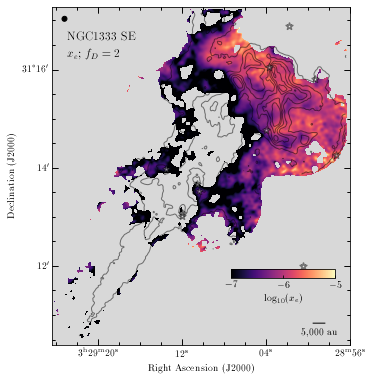

In [19]:
text_color = 'black'

hdu = load_cutout(file_xe_fd2)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-7.0, vmax=-5.0, cmap=cmap, origin='lower') #  

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(x_e)$', orientation='horizontal')
cbar.set_ticks([-7, -6, -5])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$x_e$; $f_D=2$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_xe_fd_2.pdf', dpi=200)

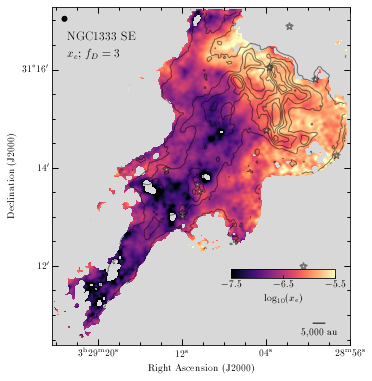

In [20]:
text_color = 'black'

hdu = load_cutout(file_xe_fd3)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-7.5, vmax=-5.5, cmap=cmap, origin='lower') #  

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(x_e)$', orientation='horizontal')
cbar.set_ticks([-7.5, -6.5, -5.5])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$x_e$; $f_D=3$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_xe_fd_3.pdf', dpi=200)

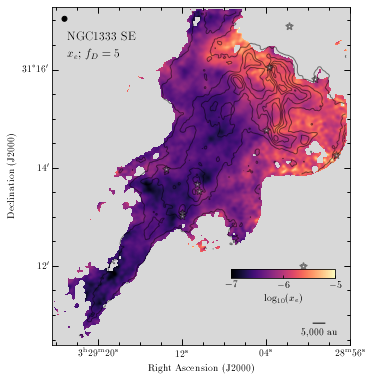

In [21]:
text_color = 'black'

hdu = load_cutout(file_xe_fd5)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-7, vmax=-5, cmap=cmap, origin='lower') #  

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(x_e)$', orientation='horizontal')
cbar.set_ticks([-7, -6, -5])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$x_e$; $f_D=5$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_xe_fd_5.pdf', dpi=200)

## CO Depletion

The CO Depletion is calculated form the Herschel data. First step, is to removme any offset.

(-1000000000000000.0, 1e+16)

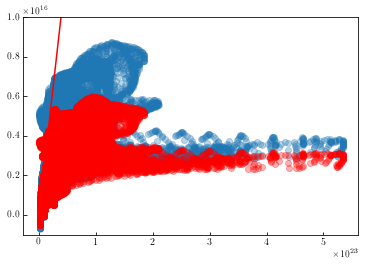

In [22]:
xrange = np.array([0, 5e23])
plt.scatter(N_H2, N_C18O, alpha=0.3)
plt.scatter(N_H2, N_C18O_Td, alpha=0.3, color='red')
plt.plot(xrange, xrange * X_C18O, color='red')
plt.ylim(-0.1e16, 1e16)

(-1000000000000000.0, 1e+16)

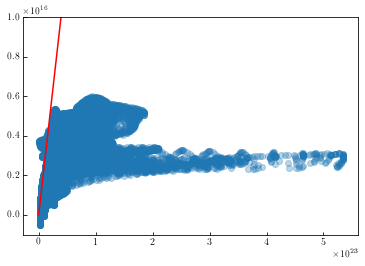

In [23]:
xrange = np.array([0, 5e23])
plt.scatter(N_H2, N_C18O_Td, alpha=0.3)
plt.plot(xrange, xrange * X_C18O, color='red')
plt.ylim(-0.1e16, 1e16)

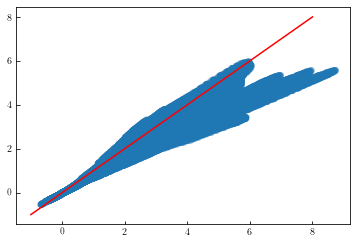

In [24]:
plt.scatter(N_C18O/1e15, N_C18O_Td/1e15, alpha=0.3)
plt.plot([-1,8], [-1,8], color='red')

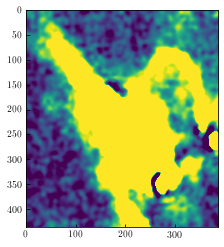

In [25]:
plt.imshow((N_H2 - N_C18O / X_C18O)/1e22, cmap='viridis', vmin=0, vmax=1)

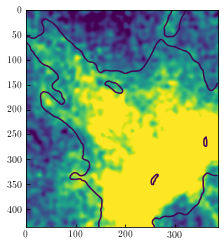

In [26]:
plt.imshow(N_C18O/X_C18O/1e22, cmap='viridis', vmin=0, vmax=1)
plt.contour(N_H2 / 1e22, levels=[1])

In [27]:
f_d = (N_H2 - 1e22) * X_C18O / N_C18O
bad = (N_H2 < 1e22) | (f_d < 1.0)
f_d[bad] = np.nan
print(np.nanmin(f_d), np.nanmax(f_d))

1.0000141711624677 44.39471728305365


In [28]:
hd_d['BMAJ']*3600

6.216735729708

In [29]:
hd_d_JCMT = hd_d.copy()

In [30]:
hd_d_JCMT['BMAJ'] = 16./3600.
hd_d_JCMT['BMIN'] = 16./3600.

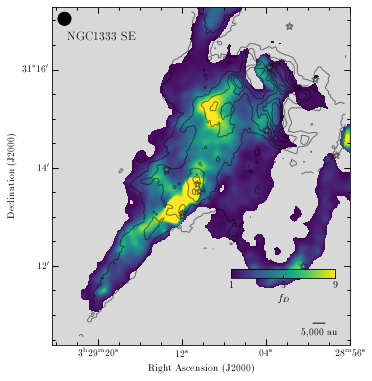

In [31]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU((f_d), hd_d_JCMT), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='viridis').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=1.0, vmax=9, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$f_D$', orientation='horizontal')
cbar.set_ticks([1, 5, 9])
fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_fd.pdf', dpi=200)

In [32]:
xe_fd = 2.7e-8 / R_d - 1.2e-6 / f_d

/var/folders/2n/6gk_yf0d1zvdwj6wy12h_klr0000gn/T/ipykernel_44747/91055284.py:3: RuntimeWarning: invalid value encountered in log10
  hdu = load_cutout(fits.PrimaryHDU(np.log10(xe_fd), hd_d), is_hdu=True)


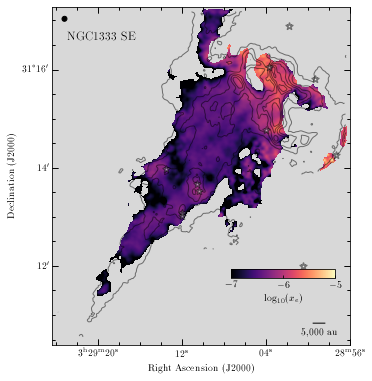

In [33]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(np.log10(xe_fd), hd_d), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-7, vmax=-5, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(x_e)$', orientation='horizontal')
cbar.set_ticks([-7, -6, -5])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_xe_fd.pdf', dpi=200)

/var/folders/2n/6gk_yf0d1zvdwj6wy12h_klr0000gn/T/ipykernel_44747/3157344349.py:1: RuntimeWarning: invalid value encountered in log10
  log_xe = np.log10(xe_fd)


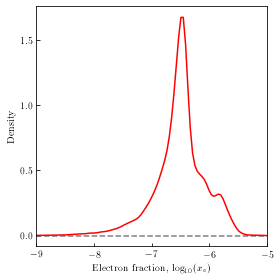

In [34]:
log_xe = np.log10(xe_fd)

xrange = np.array([-9, -5])

gd_xe = np.isfinite(log_xe)
# wt = 1 / NH3_dv[log_xe]**2
#
kde_log_xe = stats.gaussian_kde(log_xe[gd_xe])#, weights=wt)
x_sample = np.linspace(xrange[0], xrange[1], num=100)
log_xe_sample = np.reshape(kde_log_xe(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, log_xe_sample, color='red', label=r'$\sigma_v$')
#
# ax.text(0.05, 0.9,  r'$\sigma_v$(NH$_3$)', color=color_kde[0],
#         transform=ax.transAxes, size=17, weight=60)
ax.set_xlabel(r"Electron fraction, $\log_{10}(x_e)$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)

# ax.xaxis.set_minor_locator(MultipleLocator(0.025))
# ax.yaxis.set_minor_locator(MultipleLocator(2.5))

# ax.set_xticks([0.05, 0.1, 0.15, 0.2])
ax.set_yticks([0, 0.5, 1, 1.5])
plt.tight_layout()                                                      
fig.savefig('figs/NGC1333_log_xe_KDE.pdf', dpi=100)

In [35]:
sigma_levels = np.array([0.5, 1.0, 1.5, 2.0])
sigma_levels_l = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
filled_levels = np.hstack([0, sigma_levels])  # 9000 sigmas ~ np.inf
filled_levels_l = np.hstack([0, sigma_levels_l])  # 9000 sigmas ~ np.inf
levels_norm = np.exp(-0.5 * sigma_levels ** 2)[::-1]
levels_norm_f = np.exp(-0.5 * filled_levels ** 2)[::-1]
levels_norm_l = np.exp(-0.5 * filled_levels_l ** 2)[::-1]


color_kde = ['#e41a1c', '#377eb8', '#a65628']
color_levels = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c',
                '#fd8d3c', '#fc4e2a', '#e31a1c', '#b10026']
color_levels2 = ['#deebf7', '#c6dbef', '#9ecae1', '#6baed6',
                 '#4292c6', '#2171b5', '#08519c', '#08306b']


fd_min = 1.0
fd_max = 30
xe_min = -9
xe_max = -5
gd_map = np.isfinite(f_d * log_xe)
my_X = f_d[gd_map]
my_Y = log_xe[gd_map]

xx_fd_xe, yy_fd_xe = np.mgrid[fd_min:fd_max:100j, xe_min:xe_max:100j]
positions = np.vstack([xx_fd_xe.ravel(), yy_fd_xe.ravel()])
values = np.vstack([my_X, my_Y])
kernel_fd_xe = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_fd_xe(positions).T, xx_fd_xe.shape)

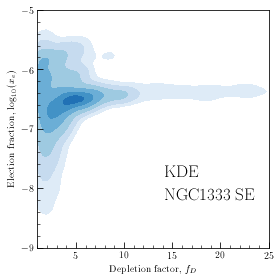

In [36]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * my_Z.max()
cfset = ax.contourf(xx_fd_xe, yy_fd_xe, my_Z, colors=color_levels2, 
                    levels=levels_norm_l * my_Z.max())
# binned values
# ax.hlines(bin_means_Tk_H2, bin_edges_Tk_H2[:-1], bin_edges_Tk_H2[1:], 
#           colors='black', lw=2, alpha=0.7)
ax.set_xlim([1, 25])

ax.set_xlabel(r"Depletion factor, $f_D$")
ax.set_ylabel(r"Election fraction, $\log_{10}(x_e)$")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.2,  r'NGC1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
# ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(H$_2$)', color='black', 
#         transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.3,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
# ax.set_xticks([0, 2, 4, 6])
ax.set_yticks([-9, -8, -7, -6, -5])
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

plt.tight_layout()
#
fig.savefig('figs/NGC1333_log_xe_fd_KDE.pdf', dpi=100)

## Cosmic Ray ionization rate

$\zeta = [7.5\times 10^{-4} x(e) + \frac{4.6\times 10^{-10}}{f_D}] 
x(e)\, n(H_2)\, R_H$ 

Where $R_H = [{\rm HCO}^+]/[{\rm CO}]$. At this moment, I have derived the CO column density, but not the HCO$^+$. So, I will use a $R_H$ that has a mean of $\sim 10^{-5.5}$.

Also, we will assume a density of $10^3$ cm$^{-3}$.

In [37]:
N_CO = N_C18O * R_12CO_C18O
HCOp_TdV, hd_TdV = fits.getdata(file_TdV_H13COp, header=True)
R_H_raw = HCOp_TdV / N_CO

R_H_med = R_H_raw / np.nanmean(R_H_raw) * 3e-6
n_H2 = 1e3
print(np.nanmean(N_CO))

1.1213630568009505e+18


In [38]:
from molecular_columns import col_h13cop
# H12CO+ / H13CO+ = 70
HCOp_Ncol = col_h13cop.H13COp_thin(J_up=1, Tex=10.0*u.K, TdV=HCOp_TdV*u.K*u.km/u.s) * 70.0
R_H = HCOp_Ncol.to(u.cm**-2) / (N_CO*u.cm**-2)
print(np.nanmean(HCOp_Ncol)/1e18)

9.432646424807856e-05 1 / cm2


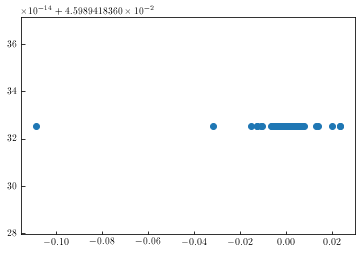

In [39]:
plt.scatter(R_H, R_H_med/R_H)

In [40]:
print(col_h13cop.H13COp_thin(J_up=1, Tex=4.16*u.K, TdV=1*u.K*u.km/u.s)/4e-9 * 89./70.)

4.970360240809212e+20 1 / cm2


In [41]:
zeta = (7.5e-4 * xe_fd + 4.6e-10/f_d) * xe_fd * R_H * n_H2
print(np.nanmean(zeta))

2.139636767301163e-17


/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


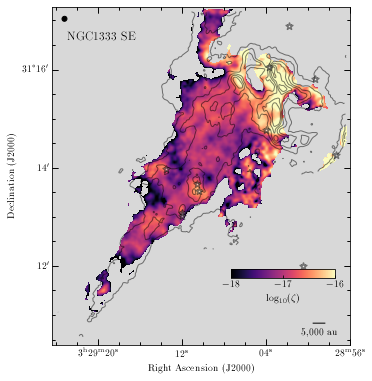

In [46]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(np.log10(zeta), hd_d), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-18, vmax=-16, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_sio=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(\zeta)$', orientation='horizontal')
# cbar.set_ticks([-19, -18, -17])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
fig.savefig('figs/NGC1333_Zeta.pdf', dpi=200)

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


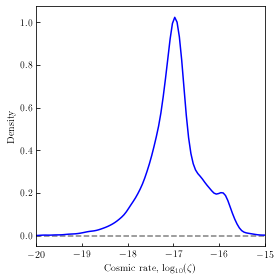

In [51]:
log_zeta = np.log10(zeta)

xrange = np.array([-20, -15])

gd_zeta = np.isfinite(log_zeta)
# wt = 1 / NH3_dv[log_xe]**2
#
kde_log_zeta = stats.gaussian_kde(log_zeta[gd_zeta])#, weights=wt)
x_sample = np.linspace(xrange[0], xrange[1], num=100)
log_zeta_sample = np.reshape(kde_log_zeta(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, log_zeta_sample, color='blue')
#
# ax.text(0.05, 0.9,  r'$\sigma_v$(NH$_3$)', color=color_kde[0],
#         transform=ax.transAxes, size=17, weight=60)
ax.set_xlabel(r"Cosmic rate, $\log_{10}(\zeta)$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)

# ax.set_xticks([0.05, 0.1, 0.15, 0.2])
# ax.set_yticks([0, 0.5, 1, 1.5])
plt.tight_layout()                                                      
fig.savefig('figs/NGC1333_log_zeta_KDE.pdf', dpi=100)

In [61]:
log_zeta_min = -19
log_zeta_max = -15

log_H2_min = 22.2
log_H2_max = 24.0

log_H2 = np.log10(N_H2)

gd_map = np.isfinite( 1./ (log_H2 * log_zeta))
my_X = log_H2[gd_map]
my_Y = log_zeta[gd_map]

xx_log_H2_zeta, yy_log_H2_zeta = np.mgrid[log_H2_min:log_H2_max:100j, log_zeta_min:log_zeta_max:100j]
positions = np.vstack([xx_log_H2_zeta.ravel(), yy_log_H2_zeta.ravel()])
values = np.vstack([my_X, my_Y])
kernel_log_H2_zeta = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_log_H2_zeta(positions).T, xx_log_H2_zeta.shape)

/var/folders/2n/6gk_yf0d1zvdwj6wy12h_klr0000gn/T/ipykernel_44747/3210220824.py:7: RuntimeWarning: invalid value encountered in log10
  log_H2 = np.log10(N_H2)


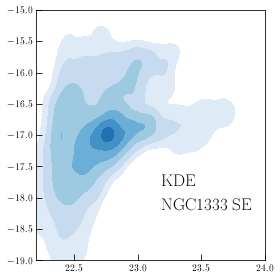

In [62]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * my_Z.max()
cfset = ax.contourf(xx_log_H2_zeta, yy_log_H2_zeta, 
                    my_Z, colors=color_levels2, 
                    levels=levels_norm_l * my_Z.max())
# binned values
# ax.hlines(bin_means_Tk_H2, bin_edges_Tk_H2[:-1], bin_edges_Tk_H2[1:], 
#           colors='black', lw=2, alpha=0.7)
# ax.set_xlim([1, 25])

# ax.set_xlabel(r"Depletion factor, $f_D$")
# ax.set_ylabel(r"Election fraction, $\log_{10}(x_e)$")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.2,  r'NGC1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
# ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(H$_2$)', color='black', 
#         transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.3,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
# ax.set_xticks([0, 2, 4, 6])
# ax.set_yticks([-9, -8, -7, -6, -5])
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.2))

plt.tight_layout()
#
# fig.savefig('figs/NGC1333_log_xe_fd_KDE.pdf', dpi=100)

[]

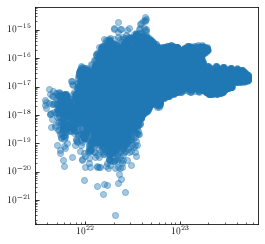

In [50]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(N_H2[gd_zeta] - 1e22, zeta[gd_zeta], alpha=0.4)
plt.loglog()

[]

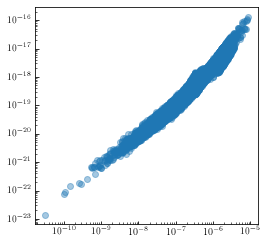

In [249]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(xe_fd[gd_zeta], zeta[gd_zeta], alpha=0.4)
plt.loglog()